In [64]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/home/kevin/Downloads/Student Feedback Surveys-Superview.csv')

In [3]:
# Remove the few rows where rating errors out.
# was originally going to dropna but didnt want to lose all the other columns info.
df = df.loc[df['Rating (Num)'] != '#ERROR!']

In [4]:
df.loc[:, 'Rating (Num)'] = df.loc[:, 'Rating (Num)'].astype(int)

In [5]:
df.columns

Index(['ID', 'Location', 'Track', 'Week', 'Rating (Num)', 'Schedule Pacing'], dtype='object')

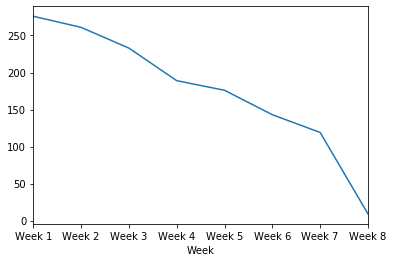

In [6]:
df.groupby('Week')['Track'].count().plot()

The dropoff in week 8 is so high I might consider dropping the week entirely to prevent missinformation

In [7]:
def promoter_level(rating):
    ''' Something to note is that there are 0's in the data 
    Despite the responses being from 1-10
    I feel like its because in the early phases it was 0-10, and in that case the data is still good.
    '''
    if rating < 0 or rating > 10:
        raise ValueError('Number out of bounds')
    
    if 9 <= rating <= 10:
        return 'Promoter'
    
    elif 7 <= rating <= 8:
        return 'Passive'
    
    else:
        return 'Detractor'

In [8]:
df['Category'] = df.loc[:, 'Rating (Num)'].apply(promoter_level)

In [35]:
def calculate_nps(series):
    counts = series.value_counts()
    for kind in ['Promoter', 'Passive', 'Detractor']:
        if kind not in counts:
            counts[kind] = 0
    return (counts['Promoter'] - counts['Detractor']) / sum(counts)

In [36]:
f"Overall NPS score: {calculate_nps(df['Category'])}"

'Overall NPS score: 0.4406896551724138'

# Weekly NPS score 
With overall nps score plotted in red

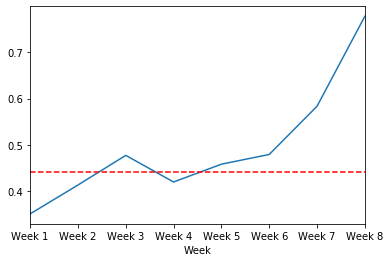

In [42]:
ax = df.groupby('Week')['Category'].agg(calculate_nps).plot()
ax.axhline(calculate_nps(df['Category']), color='r', linestyle='--')

# Plot of category changes over time
with respect to the change in number of responses

In [150]:
pd.crosstab(df['Category'], df['Week'])

Week,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,Week 7,Week 8
Category,,,,,,,,
Detractor,28,23,20,19,15,8,8,0
Passive,131,116,86,74,67,59,34,2
Promoter,129,137,135,100,97,77,78,7


In [151]:
pd.crosstab(df['Track'], df['Week'])

Week,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,Week 7,Week 8
Track,,,,,,,,
Apps,183,176,142,105,101,88,72,4
"Apps, Explorer",42,40,38,34,31,23,16,0
Games,35,29,36,33,31,21,19,4
"Games, Explorer",6,6,7,7,6,6,5,0
VR,10,10,10,10,7,5,7,1


In [67]:
weekly_ratio = lambda cat: df.loc[df['Category'] == cat].groupby('Week')['Category'].count()/df.groupby('Week')['Category'].count()

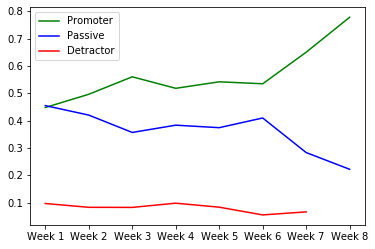

In [76]:
fig, ax = plt.subplots()
ax.plot(weekly_ratio('Promoter'), label='Promoter', c='Green')
ax.plot(weekly_ratio('Passive'), label='Passive', c='Blue')
ax.plot(weekly_ratio('Detractor'), label='Detractor', c='Red')

plt.legend()

## Take a look at pacing compared to category

Turn the pacing into numerical form, counting from 0-2 depending on the perceived pacing

In [91]:
df['Schedule Pacing'].unique()

array(['Just right', 'A little too fast', 'Way too slow',
       'A little too slow', 'Way too fast'], dtype=object)

In [92]:
pacing_ord_map = {'Way too slow': 0, 'Way too fast': 0, 'A little too slow': 1, 'A little too fast': 1, 'Just right': 2}

In [94]:
df['schedule_ord'] = df['Schedule Pacing'].map(pacing_ord_map)

Well this is interesting, why did half the detractors say the pacing was just right??<br />
This leads me to believe there are other factors that are heavily affecting their enjoyment

In [103]:
pd.crosstab(df['schedule_ord'], df['Category'], normalize='columns')

Category,Detractor,Passive,Promoter
schedule_ord,,,
0,0.099174,0.017575,0.006579
1,0.363636,0.318102,0.215789
2,0.537190,0.664323,0.777632


It looks like 

In [143]:
all_cat = df.groupby('schedule_ord')['Track'].value_counts().rename('Count').reset_index()

pd.pivot_table(all_cat, index='schedule_ord', columns='Track', values='Count')

Track,Apps,"Apps, Explorer",Games,"Games, Explorer",VR
schedule_ord,,,,,
0,13.0,7.0,4.0,NaN,NaN
1,255.0,52.0,46.0,5.0,15.0
2,603.0,165.0,158.0,38.0,45.0


In [144]:
detractors = df.loc[df['Category'] == 'Detractor'].groupby('schedule_ord')['Track'].value_counts().rename('Count').reset_index()

pd.pivot_table(detractors, index='schedule_ord', columns='Track', values='Count')

Track,Apps,"Apps, Explorer",Games,VR
schedule_ord,,,,
0,7.0,2.0,2.0,NaN
1,29.0,6.0,2.0,1.0
2,42.0,16.0,5.0,1.0


## Conclusion
A large part of the people who thought it was too fast or too slow were from the detractors <br />
But most detractors didn't seem to have a problem with the content.

# Lets look at tracks
First trying to see how similar the , explorers are to the non.

In [145]:
pd.crosstab(df['Track'], df['Category'], normalize='index')

Category,Detractor,Passive,Promoter
Track,,,
Apps,0.089552,0.407577,0.502870
"Apps, Explorer",0.107143,0.486607,0.406250
Games,0.043269,0.317308,0.639423
"Games, Explorer",0.000000,0.279070,0.720930
VR,0.033333,0.200000,0.766667


It looks like most tracks have high promoter counts, with app explorer falling the furthest behind.<br />
App comes in second. However they do both hold the highest number of people so theres a good chance <br />
Its a track for those who didnt really have a lot of passion too.

In [146]:
pd.crosstab(df['Track'], df['schedule_ord'], normalize='index')

schedule_ord,0,1,2
Track,,,
Apps,0.014925,0.292767,0.692308
"Apps, Explorer",0.031250,0.232143,0.736607
Games,0.019231,0.221154,0.759615
"Games, Explorer",0.000000,0.116279,0.883721
VR,0.000000,0.250000,0.750000


Nobody had huge problems with the pacing, although only about 75% of people thought the pacing was just right

In [147]:
df

,ID,Location,Track,Week,Rating (Num),Schedule Pacing,Category,schedule_ord
0,134,San Francisco,"Apps, Explorer",Week 1,3,Just right,Detractor,2
1,36,Los Angeles,Apps,Week 1,4,A little too fast,Detractor,1
2,117,San Francisco,Games,Week 1,4,Way too slow,Detractor,0
3,253,NaN,NaN,Week 2,4,A little too fast,Detractor,1
4,350,New York City,"Apps, Explorer",Week 1,4,Just right,Detractor,2
...,...,...,...,...,...,...,...,...
1448,1495,New York City,"Apps, Explorer",Week 7,10,Just right,Promoter,2
1449,1496,New York City,"Apps, Explorer",Week 7,8,Just right,Passive,2
1450,1497,New York City,Apps,Week 7,10,Just right,Promoter,2
1451,1498,New York City,"Apps, Explorer",Week 7,1,A little too slow,Detractor,1
